# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [3]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(alternate_sign=False, strip_accents='ascii', lowercase=True, ngram_range=(1,3))
        
        ##### 3 changes. strip accents, lowercase, ngram_range,  ## CUT FROM ORIGINAL: n_features=2 ** 17, 
        
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
   
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")
   # toxic_data['case_count'] = toxic_data['comment_text'].str.split(' ').str.isupper()
    toxic_data['punc_count2'] = toxic_data['comment_text'].str.count("\!")
    ####new columns here 
    
    
    

    X_quant_features = toxic_data[["word_count", "punc_count", "punc_count2"]]
    
    #####
    
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [4]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='C:/Users/Dallas/Desktop/Machine Learning/toxiccomments_train.csv', my_random_seed=85)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [5]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 12979, 'Neg': 114677, 'TP': 6593, 'TN': 57202, 'FP': 57475, 'FN': 6386, 'Accuracy': 0.49974149276179736, 'Precision': 0.10290628706998814, 'Recall': 0.507974420217274, 'desc': 'ols_train'}


C:\Users\Dallas\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


### MODEL: SVM, linear

In [6]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 12979, 'Neg': 114677, 'TP': 12967, 'TN': 114664, 'FP': 13, 'FN': 12, 'Accuracy': 0.9998041611831798, 'Precision': 0.9989984591679507, 'Recall': 0.9990754295400261, 'desc': 'svm_train'}


### MODEL: logistic regression

In [7]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 12979, 'Neg': 114677, 'TP': 12959, 'TN': 114670, 'FP': 7, 'FN': 20, 'Accuracy': 0.9997884940778342, 'Precision': 0.9994601264846522, 'Recall': 0.998459049233377, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [8]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 12979, 'Neg': 114677, 'TP': 12968, 'TN': 113986, 'FP': 691, 'FN': 11, 'Accuracy': 0.9945008460236887, 'Precision': 0.9494106449959734, 'Recall': 0.9991524770783573, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [9]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 12979, 'Neg': 114677, 'TP': 12959, 'TN': 114670, 'FP': 7, 'FN': 20, 'Accuracy': 0.9997884940778342, 'Precision': 0.9994601264846522, 'Recall': 0.998459049233377, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [10]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 12979, 'Neg': 114677, 'TP': 12971, 'TN': 114669, 'FP': 8, 'FN': 8, 'Accuracy': 0.999874663157235, 'Precision': 0.9993836196933508, 'Recall': 0.9993836196933508, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [11]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 12979, 'Neg': 114677, 'TP': 0, 'TN': 114677, 'FP': 0, 'FN': 12979, 'Accuracy': 0.8983283198596227, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_train'}


C:\Users\Dallas\Desktop\Machine Learning\final_assignment_1\my_measures.py:25: RuntimeWarning: invalid value encountered in longlong_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])


### ROC plot to compare performance of various models and fits

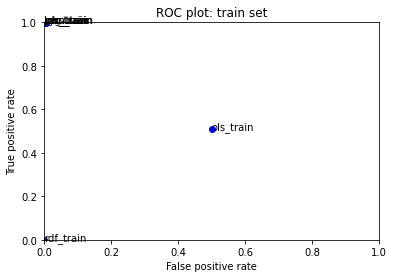

In [12]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: train set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

### let's look at some false positives:

In [13]:
ols_predictions = ols.predict(X_train)

In [14]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false positives:
26
"::::""Sneer""?  That's not NPOV!!!  (talk) 

"
* * * * * * * * * 
48
"
I think that's the best move for now. The article can always be moved later. I'll have to look at how Wikipedia handles authors - whether they have the articles under pen names or actual names.  Talk "
* * * * * * * * * 
194
in his edit summaries in response. then
* * * * * * * * * 
235
"

I'm just telling facts... One who doesn't take to Krishna consciousness - is most condemned and cannot be delivered for millions of kalpas (kalpa = 1000*10*432000 years):
""Śrī Caitanya Caritāmṛta Antya 3.255

e-vanyāya ye nā bhāse, sei jīva chāra
koṭi-kalpe kabhu tāra nāhika nistāra
SYNONYMS

e-vanyāya — in this inundation; ye — anyone who; nā bhāse — does not float; sei — that; jīva — living entity; chāra — most condemned; koṭi-kalpe — in millions of kalpas; kabhu — at any time; tāra — his; nāhika — there is not; nistāra — deliverance.
TRANSLATION

""Anyone who does not float in this inundation i

4300
Tedder, 

Thanks for the update. earlier I expressed that I would leave the page be. Do you agree?? If not, would there be a problem?
* * * * * * * * * 
4316
Go ahead and delete it. All the info just got moved to The big show (sports radio show)
* * * * * * * * * 
4387
A Warning About Racist Amandajm
Amandajm has repeatedly made so many racist comments about certain europeans on the Castle article that I sent a complaint to wiki editors. This person is extremely inflexible when other people trg to correct info on the Castle article. When attempts about updating history about Spaniards and italians were made on the Castile article, Amandajm did not allow such edits. Such stubbborness is considered racist. He refuses to acknowledge certain european history and contribution. I ask that others watch this person since he is deceptive. If any of you have experienced similar action by Amandajm, it is strongly recommended that you voice your concerns about his racism to wiki.
* * * * * * 

6737
I meant the last 2 comments, The one that gave me a warning and final warning.
* * * * * * * * * 
6785
"
Le Grand, you are not innnocent. So why do you continue to act like the victim here? You twisted many of the things around on me. I talked with Ran on his talk page about you, that's the only case you are right about. The other cases you assume (collectarian and Judgesurreal's talk pages): I didn't mention your name once. Instantly assuming things isn't helping matters. It's clear you haven't avoided me either, the list of Ring of Honor events AFD (which I believe you explained with: ""I'm part of the wrestling project"") is one example. Project members aren't required to visit/post in AFDs of the project's scope. You could've had restraint there, but didn't. The fact you come here to harass me during a block, is also bad faith in my view. In response to McJeff's RFC link he provided, see this section: /Wikipedia:Requests_for_comment/RobJ1981#Findings. It was found that McJeff 

9259
Ok, thank you! I thought it was something like that! Yeah, I think it is a fake name. I don't know if you know the movie, but you maybe know the book writen by André Brink? �
* * * * * * * * * 
9267
Image:Jake Gyllenhaal.jpg 

I'm not sure I understand what you are saying.  Even if it is a HDTV screenshot, there is still a copyright belonging to the producers of the film or television show or wherever it came form.  Where exactly did the image come from?
* * * * * * * * * 
9285
"

 Bitter tangerine? 
""The taste is often described as more sour than an orange and less bitter than a tangerine, however, and is more commonly guessed to be a lemon-tangerine hybrid.""
I've never tasted a bitter tangerine, only sweet or sour. Is this correct?"
* * * * * * * * * 
9325
new experience
Now our Hollerberg is actually gone ) It looks as if i have to rethink my anticipation of enwiki always keeping such pages. Only out of curiosity: did you tag it for deletion, or did the admin act spontanously

12361
"

Every reasonably written history of mathematics makes a clear point of emphasizing Cantor's Jewish identity (see, for example, Carl
Boyer's competent study wherein it is Cantor's father is a convert and his mother having gentile origins. Historiography is not as straight forward as the amateur historians herein would purport to assert. One has to put Cantor in the context of the period in Jewish history in which he lived. Cantor lived at the time when the failed ""German-Jewish symbiosis"" was still believed possible. It was a time when the poet Heinrich Heine could, and did, assert that conversion to christianity was his ""entry ticket to German society."" The same is also manifestly true of Cantor."
* * * * * * * * * 
12429
"

 Happy New Year/ Our discussion 

Hi Zora, wishing you a Happy New Year. I was on wikibreak the last couple of days and the thread on ANI got archived in the meanwhile. May I know your current stand on it? If you still have objections to the template o

14654
"

Croatian Women's Cup finals
I stumbles upon a Croatian newspaper archive. http://library.foi.hr/nv/default.aspx?G=1&u;= Those newspapers cover football at like 3 pages per day. I wondered if one is able to find results or at least runner-ups from 1992 to 2001. As i don't speak Croatian and don't know the dates of the finals, i can't come up with good searchterm to create few good results. Maybe you could have a short try at that site? Something like women's cup final, women's football, year final, or cupwinner + final or something. Thanks in advance. -  

Attendances
Info is taken from annual yearbooks (Almanah YU fudbala) published after each season. I'll add it a as a non-linked source.99.255.217.164  

 Article importance assessment drive... 

Whoa! I was this close to raising an issue with the WP 1.0 bot, because it looked like it was almost 100 articles off, and noone is assessing that many articles a day... -)   
All in a day's work ;-) Mind you, 99% of everything I asse

17019
As always, other sources are welcome.
* * * * * * * * * 
17028
Hrm... I am sorry if this is an unnessesery question but... How do I do to use the user box? (I expect I should use my username). 
/
* * * * * * * * * 
17098
You would like that wouldn't you KIng Bee and Isotope23, but no material is being deleted and there is no interest in deleting material like King bee would like you to believe, all that is happening is the addition of correct and factual stats, heck, King Bee and Jaranda won't even allow the addition of three direct link to stats of Brett Favre's from espn, cbs and SI, it's getting sad, they are ruing this page of being up to date or anything, it's pure bullying and they should be stopped, only correct and factual stats are trying to be added, no deleting, even a new cit was added, but they delete that too, King Bee and Jaranda and vandalisng the page and getting away with it also, King Bee broke the 3RR rule on the Brett Favre discussion page and Brett Favre mai

Heh, there wasn't enough drama on his page to keep my attention. As for Nancy, I'm not up for in-depth discussion right now, so she's gonna have to wait. Have a good weekend! ricks "
* * * * * * * * * 
19550
10 years is temporary, similarly can be 100 years, but the best way is to not use the temporary word and state the present lack of capability rather than furtutistic words like temporary, hopefully, ...
* * * * * * * * * 
19568
Also, I did stop making any edits to the other articles once you stepped in, so your ban is also unjustified as I was making no attempt to edit the articles again until the dispute was resolved, it's not my fault it took you so long to play catch up. 72.72.240.141
* * * * * * * * * 
19603
"

 Bad news; looking into the article history, this isn't stable (failing GA criterion#5) given how there have been massive changes recently and content disputes. That alone is an automatic fail I'm afraid. Here's some other comments from a glance:

Having a really large n

Please do not re-add list of fallen officers in this article. Every place, building and organization has had people die there unless it is brand new. While they may deserve a memorial, this encyclopedia is not it. Please see WP:NOTMEMORIAL. I'm sure you mean well, but I will have to take further steps if you persist in adding material that is clearly in opposition to Wikipedia policy.
* * * * * * * * * 
22488
"

 82.43.210.155 

Hope you don';t mind, but I extended your block of 82.43.210.155 to one week.  It was the second time and the vandalism was pretty bad.  First 24 hour block didn't seem to do the trick so I felt one week may.  No problems if you want to use your time, I just wanted to notify you of the change. (talk) 

 Thanks 

...for reverting vandalism to my user page. — (?) Seen this already? 

 I know two of your brothers 

: )  e (talk / contribs) 

 Moline 2 

A few days ago I asked you why you reverted my efforts on the Moline, Illinois page and either I didn't get a re

24936
Thanks for your message. I have already spent far too much time on the issue, so that I shall not take any further action. J Milburn's argument is faulty: one cannot remove an image on the possibility of the events that may or may not take place in the future; the relevant question is whether my copyright statement is incorrect at the time being, and the answer to this is clearly in the negative (at least Milburn has not come up with a free image of Michael Foot, thereby showing that my copyright statement were invalid) so that the image must stay. I have argued, but to no avail, that when a free image turns up (there is no a priori reason why a free image should at all become available at any foreseeable time from now), that event renders my present copyright statement invalid, at which instance the present image must be replaced by the available free image. At present no law is violated, so that there is no reason why the image should be removed. But I have said this many times

27614
down.  There are better adminstrator.  She didn't do a fantastic job, other than moderating like she owns the place.
* * * * * * * * * 
27694
List of Suicides
thanks for the notice. My only thought is that the article should not assume suicides just because somebody for example may have overdose. An overdose is not necessarily a suicide. I mentioned something about that before last year. But that's all I can come up with. It's good article.
* * * * * * * * * 
27718
, 17 July 2006 (UTC)

Furthermore why make words be spelt -ize instead of -ise as they become -ism not -izm?  10:26
* * * * * * * * * 
27787
That's not me.202.156.13.11
* * * * * * * * * 
27828
Wrong! Busby describes it a Chernobyl event, it is Fells that likens it to Three Mile Island (where NO radiation is claimed to have been leaked). Please get use correct facts, you have berated me for errors.   18:59 18 April 2011 (UTC)
* * * * * * * * * 
27829
"
That'll work.  Would you mind stiking my comment (the one that got 

30252
Illegal usernames 
Personally I think this approach  counts as biting Newbies, especially after only a single edit. I think you should really offer to move the account to a new name to them, it may be a little more work but is generally much less contra WP:BITE.  talk
* * * * * * * * * 
30270
"

Russian topography and administration

Hello,

there was no Ugodski-Zavod raion in tsarist era, I was wrong, sorry. The tsarist-era raion was
of larger scale than later soviet-era raion. 
- therefore is right: ""born in ...Maloyaroslavets raion"".

Does anyone know when the place (PGT) UGODSKI ZAVOD was renamed ""ZHUKOVO"" in Georgi K. Zhukov's honor ?

Thanks,
WernerE (germanwiki), 25.2.05
"
* * * * * * * * * 
30306
"

Welcome!

Hello, Imtiyazgujjar, and welcome to Wikipedia! Thank you for your contributions. I hope you like the place and decide to stay. Unfortunately, one or more of the pages you created, such as Karianwala, may not conform to some of Wikipedia's guidelines for page cre

32721
"

 Connie talbot  Holiday magic DVD 

word just in from AAO music, ""Connie Talbot's Holiday Magic"" DVD, has reached #1 on the music DVD charts in Hong Kong. see this thread for further info http://connietalbot.proboards.com/index.cgi?board=shawn1&action;=display&thread;=2717&page;=1

  "
* * * * * * * * * 
32782
"

 About Einstein 

My search of any document that might bear Einstein's name - in the League of Nations archive - in between 1930 - 1932 returns no results. See http://biblio-archive.unog.ch/archivplan.aspx.  By reviewing five books dealing with Einstein's work and life - not a single one mentioned this Einstein's support to the Ustase cause. Just one, written in German,

Einstein: Sein Leben by Denis Brian, Christine von Samson-Mark, Wiley-VCH, 2005 page 352

Indem er sich den Angelegenheiten seines eigenen Landes zuwandte, empoerte sich Einstein ueber deutsche Studenten, die fuer die Entlassung eines Professors agitierten, weil dieser ein Pazifist gegen politisch m

35448
NO, English, is a Germanic language, because in history, English grew out of Old Germaniclater adoptions of Latin vocabulary were not foreseen!
 01:11, 23 Aug 2004 (UTC)
* * * * * * * * * 
35449
Oh I see! Thanks for tip
* * * * * * * * * 
35458
"I have clarified the ""anti-DRM"" issue... I thought that the phrasing, as it was, seemed to say this: ""Debian doesn't like CC because it's anti-DRM!"". For what I read, the problem with CC is the ""anti-DRM"" clause isn't clear enough and can be (mis)interpreted. 

"
* * * * * * * * * 
35499
REDIRECT Talk:Hamilton (GRTC Pulse station)
* * * * * * * * * 
35513
Common knowledge in this context, means that it is easy to reference. — | Talk
* * * * * * * * * 
35520
My apologies. I have replied thereat.
* * * * * * * * * 
35568
Delete this farcical article 
New anti-Semitism is a myth.  It is not encyclopaedic to even have an article on this.  It is supporting the anti-semitic point of view by justifying their position that Jews deserve the 

38668
I'm glad to see rhetoric is not dead in the Australian Labor Party. John
* * * * * * * * * 
38747
Picture
I don't know the source of it. I took it from a webpage years ago in the belief that it was an old image, but I now have a suspicion that it may be a quite recent painting.
* * * * * * * * * 
38756
"

 Regarding the speedy deletion of ""Suffokate"" 

What was wrong with the ""Suffokate"" article? People were trying to create an article about this band several times already and I bet that even more people were trying to find an article about this band on Wikipedia and you together with  think it is insignificant?   "
* * * * * * * * * 
38783
Says flinging babies into the Ganges was commonplace
* * * * * * * * * 
38785
Teahouse question answered
* * * * * * * * * 
38805
future tense 

This article has a lot of saying that such-and-such will happen. Aside from the fact that we cannot predict with certainty whether the work will be successfully completed as planned, it is also a 

40940
"
Okay, thanks. I was not aware.  "
* * * * * * * * * 
40975
Cultural references
I wonder what sense it makes to have a a saying similar to the last words in a song by Ozzy Osborne, etc. Not that I have ever listened to that person, but the applicability of that type of reference seems to be very weak to me. I suggest a vote that the section should be deleted. Please add votes/comments about the section to see if it should stay or go.

 delete section.
* * * * * * * * * 
40988
Do not remove speedy tags
Please stop removing speedy deletion notices from articles that you have created yourself. If you do not believe the article deserves to be deleted, then please do the following:
 Place  {{hangon}} on the page. Please do not remove any existing speedy deletion notice(s)
 Make your case on the article's .
Administrators will look at your reasoning before deciding what to do with the article. Thank you.
* * * * * * * * * 
40989
"

 Civility 
Regarding edits such as this: Please do no

43865
Trochilus
Can't be a hummingbird, as these only became known post-1492 AD. Maybe a kinglet.
* * * * * * * * * 
43866
Music section 

Does Paul Simon not warrant a mention?
* * * * * * * * * 
43889
"
Welcome

Hello and welcome to Wikipedia!  We appreciate encyclopedic contributions, but some of your recent edits do not conform to our policies.  For more information on this, see Wikipedia's policies on vandalism and limits on acceptable additions. If you'd like to experiment with the wiki's syntax, please do so on Wikipedia:Sandbox rather than in articles.

If you still have questions, there is a new contributor's help page, or you can write {{helpme}} below this message along with a question and someone will be along to answer it shortly.  You may also find the following pages useful for a general introduction to Wikipedia.
The five pillars of Wikipedia
How to edit a page
Help pages
Tutorial
How to write a great article
Manual of Style
Policy on neutral point of view
Guideline on 

46264
", 11 April 2008 (UTC)

 and igff the bearers simply let it go, there'd be no violence... 
 That sounds almost like the Tibetan government-in-exile's claim that ""violence to a Tibetan is killing someone; if you don't kill them, and only beat them up, and they run away, it's not violence"" (I'm paraphrasing, but the exact quote is in 2008 Tibetan unrest.)  but you'd probably resent that comparison.
 Let's try an almost exact analogy: ""The robbery victim should have just divvied up all the cash to the robber. If she'd just let go, there wouldn't have been any violence"". Or: ""Britain should have just surrendered. If they had just let go of their country, there wouldn't have been a war"". What's wrong is wrong is wrong. A person has the right to defend their person and legally obtained possession, and you can't justify crime (not including political crimes) or violence against a civilian by a political cause. 
 Yes, the flame attendants themselves are idiots, too, and they are ""

48768
"

 confused 

""The Quran, however, provides minimal assistance for Muhammad's chronological biography; many of the utterances recorded in the Quran lack historical context.[32][33]""
Bennett's book says that the quran lacks history about the prophet but doesn't say that ""the utterances recorded in the Quran lack historical context"".
Please EXPLAIN kindly"
* * * * * * * * * 
48831
Jian Battista Calvi also referred to in the article is Giovanni Battista Calvi.
* * * * * * * * * 
48840
"

 Final Edit 

Since I'll never be editing Wikipedia again, I thought I'd add a few notes here for the benefit of the few people involved who aren't delusional.  One day, I logged on to discover that I had been accused of being someone else and was facing being banned as a result.  When I objected, instead of being banned for being someone else, I was banned for objecting.  The person who did the banning had been carrying a grudge for literally years, having been caught trying to ban me for simi

51485
Yes, Shakespeare had it right: A tale told by an idiot, Full of sound and fury, Signifying nothing. The struggle must continue until the final extirpation of our enemies! (who not only believe exactly the same, but are identical to us.) The more immediate problem is that every so often some half-wit decides to further their agenda by 'direct action' like this. You might, incidentally, be interested in the Colm Tóibín quotation found here. Best wishes,  (talk)
* * * * * * * * * 
51514
ATSB
Hi! For some reason I missed your post about the ATSB until now. Thanks for letting me know that you took the photos
* * * * * * * * * 
51548
Greatest Hits!? 

when is the GREATEST HITS album coming out???
2008 or 2009?
* * * * * * * * * 
51620
"

proposing to remove the ""Poorly sourced"" title as the content in the article is well source & defined. Inviting your opinions for the same (  )"
* * * * * * * * * 
51622
"

And what criteria do you use to determin which are the ""most-used meanings""

53908
This article is POV. It explains as if there was a civil war, when most wars were Serbia attacking Croatia, Bosnia, Kosovo, Slovenia; etc...
* * * * * * * * * 
53928
"

 Invite 

You are invited to join WikiProject Oregon, a WikiProject dedicated to improving articles related to the U.S. state of Oregon''.  You received this invitation because of your history editing Oregon articles or discussion of Oregon topics.  The Oregon WikiProject group discussion is here.If you are interested in joining, please visit the project page, and add your name to the list of participants. New members may read about existing members and introduce themselves here.  "
* * * * * * * * * 
54038
[{unblock|responding administrators don't have a solid grasp of Wikipedia policy - request experienced admins who are willing to grapple with the very serious issue of false credentials}}
* * * * * * * * * 
54179
Different Intros 

The original HBO airings of Spicy City have an intro showing lipstick markings. 

I really want to learn and co-operate with you I don't want to 'disrupt' wikipedia in anyway, I just made some bad edits. When you were new you must have made mistakes and look 95% of my edit history is good. I just made a bad judgement on the 'gay perve' case and gave the wrong warning with the image case (later reclassified the warning). I hope we can become civil, work together and maybe you could teach me some stuff.
* * * * * * * * * 
56418
Please stop adding commercial links to Wikipedia. It is considered spamming, and Wikipedia is not a vehicle for advertising. Thanks.
* * * * * * * * * 
56472
Photograph
Can we have a photo of such a family?
* * * * * * * * * 
56505
Hoax

 Please do not create hoaxes. Please do not attempt to put misinformation into Wikipedia to test our ability to detect and remove it. This has been done before, with varying results.   Most hoaxes are marked for deletion within a few hours after they are created.   Some Wikipedians suspect that the majority of 

59677
Your category tags on British Commonwealth Honours Systems is deeply offensive!

Hu, your tags on British Commonwealth Honours System-related articles
are deeply offensive. Here's an example of how politically offensive your tag is; Rhodesian Honours System. I want an apology please!-
( )
* * * * * * * * * 
59708
"

 Thanks 

 Hello ,

I wish to thank you for your vote on my RfA. It has passed with a final tally of 59/0/0. If I can ever help with anything or if you have any comments about my actions as an admin, please let me know! Self | talk  "
* * * * * * * * * 
59752
Elton Mayo
Mayo was neither an industrial psychologist nor a sociologist. See David Cullen's dissertation, A new way of statecraft: The career of Elton Mayo. Proquest Dissertations and Theses. Mayo earned a BA in philosophy and psychology at Adelaide (where the ICOH-WOPS conference will be held in September 2014). That was the highest degree he earned. If you want to learn how he got a position at HBS, read this 

62298
Please stop. If you continue to blank out or delete portions of page content, templates or other materials from Wikipedia, you will be blocked from editing.  →   —
* * * * * * * * * 
62321
"

 Does the rubberband AI section have anything to do with AI? 

The rubberband AI section section describes a situation where a computer controlled character get a bonus when losing. However in most of the examples in this section, the bonus is not related to AI, because the bonus does not make the computer controlled character smarter og it doesn't give the  computer controlled character any new information. As an example the section mentions a game where a computer controlled racing car gets a speed bonus. This bonus is not related to AI and it doesn't not belong to an article about ""Game artificial intelligence"". I suggest that the section about ""rubberband AI"" is moved to a separate article called ""rubberband bonus"".  "
* * * * * * * * * 
62384
"
Addendum - At the moment I'll be wor

64623
Maybe. as long as you stop correnting and annoying me.
* * * * * * * * * 
64649
Scjessey. I removed your post again and left a note to the ip to stop and comment only on improving the article. If he doesn't do that, or rants again, we can remove that and look to block, ect.  (talk)
* * * * * * * * * 
64689
You want to end the dispute... fine... dispute over I concede to your removal of the tag.
* * * * * * * * * 
64753
Buddhism (and Zen, by extension) are considered atheist. Which to me kind of weakens the importance of identifying all religious belief as either theistic or atheistic.
* * * * * * * * * 
64821
"
Having failed to convince those many editors who oppose the move (and thereby necessarily failed to gain consensus), it now feels as if you're trying to bludgeon me into accepting your position, or hoping that I'll give up and let this foolish idea stand.  I resent that approach, and I'm asking you to stop now.  Let the closing admin decide and don't try to sort out the le

67380
hello everyone I hope someone looks me up anytime soon!
* * * * * * * * * 
67396
Muamer Tanković 

Could you please stop your disruptive edits on Muamer Tanković. Soccerway confirms that he's made three appearances for Norrköping in 2011. Thanks,
* * * * * * * * * 
67414
== Template:Infobox National Military Albania == 

 You currently appear to be engaged in an edit war. Note that the three-revert rule prohibits making more than three reversions in a content dispute within a 24 hour period. Additionally, users who perform a large number of reversions in content disputes may be blocked for edit warring, even if they do not technically violate the three-revert rule. If you continue, you may be blocked from editing. Please do not repeatedly revert edits, but use the talk page to work towards wording and content which gains a consensus among editors.
* * * * * * * * * 
67475
A redirect would be appropriate.
* * * * * * * * * 
67490
"

 to User:John (15-12-2013) 
Could you please exp

71200
"

So overdue
  The Copyright Cleanup Barnstar Thank you for always being conscious of and responsible with copyright issues.  (talk) 

I can't believe that I haven't spammed you with one of these before. I don't remember at what point you transitioned into being one of the people on Wikipedia that I just think of as awesome in this area, but it's been such a long time ago that I would have assumed I had already popped in a picture to express my appreciation. I consider this long overdue. ) Thank you so much for keeping an eye out for this and facilitating the cleanup of so many issues. You help keep our articles ""Quality"". )  (talk) "
* * * * * * * * * 
71224
"
Awickert, this article (Deformation (mechanics) has the objective, which you propose, of discussing in one article the concept of deformation (strain). And from here to link to other, more detailed, articles about Finite and Infinitesimal deformation theories.
If some of the material that was in the article strain tenso

73512
Most of the material on the page was from a rewrite I did a few month ago. I am busy so I do not have time to work on the article so I will just give a few short notes on your rewrite. To be honest I have some issues with your edits. I answered you question above and fixed your error in the introduction of the article. 

There are two methods to define the topology of a LCTVS space: using a family of seminorms and using a local basis of locally convex, balanced and absorbend sets. Both methods should be present in the article on equal terms. The family of seminorms is useful to view LCTVS as generalizations of normed vector spaces. The definition in terms of a local base is useful if you are coming from the more abstract topological vector space concept.

The definition section is now too long and detailed. I think the subject is specialized enough so that we can assume the reader is familiar with the basic concepts which are now explained in detail in the definition.

The articl

This articl has now been nominated for deletion:  Wikipedia:Articles for deletion/Kristen Zaik.
* * * * * * * * * 
76015
Giving Warnings to both is not equivalent to Banning both. I am the only one blocked and I should not be considering how offensive and disgusting the other editor was to me.
* * * * * * * * * 
76032
"

 Why do you immediately change an edit that I made ?? 

I edit very rarely on Wikipedia.  When I do, I try to be correct, brief, and to the point.  Therefore, I take offense at you constantly deleting language I'm modifying on the ""list of regional nicknames.""

I added this > FIB 
    (U.S.) An acronym for ""Fucking Illinois Bastard."" This is frequently heard at sporting events between sports teams in Wisconsin and Illinois.

and I modified this > (additions in bold).  Cheesehead 
    (U.S.) A person from Wisconsin, from the many dairy farms and cheese factories there. Also extended to fans of the state's National Football League team, the Green Bay Packers. This te

Go away with your CIVIL stuff, mate. If you'd have a sense discussion style, you'd be able to say excuse me, you're right on that instead of ignoring whole arguments on a high horse. You may be a long-time editor here, but in this particular case my assertion stands. As for the argument on Gundell/Gardell: likely perhaps, but an assumption. You can't verify that, either, unless you are able to verify in the book. You did not state wether you verified, or not. I have to assume you are an authority somehow. Great example of how to inject untruth in Wikipedia. Next time Wikipedia's credibility is of subject somewhere, I'll be sure to reference to this case. Just to point out the obvious: as argument in that, it doesn't matter if its true or not, since the problem is that it is unclear wether its verified, or not.
* * * * * * * * * 
78548
ban 

you got me banned on irc -
* * * * * * * * * 
78564
, or simply click here
* * * * * * * * * 
78621
Elizium23, I already responded to you on my tal

80965
whats with the removal of the ibo belts on the klitschko pages?
* * * * * * * * * 
81131
"

Hi BelovedFreak, my decision happened so quickly, it didn't give much time for people to respond to the discussion. I removed the section in question, then rewrote it completely and I'm actually happier with the end result. But I learned an important lesson on the way: don't trust online sources to ""exist"" forever. Thanks for getting in touch with me anyway! – Kerαunoςcopia◁galaxies "
* * * * * * * * * 
81170
"::::::::Yes, this article is pretty short, & little of it exclusive to Arabic language calligraphy. Copy rather than ""transfer"".   
"
* * * * * * * * * 
81263
For Daniel Case
Hi Daniel. The block is extremely odd. IMO, there is no real discussion of my activity in that AN thread in connection with a siteban. Jehochman, whom I have some history with, floated the idea of a siteban. Durova, who has been on my case steady for months on behalf of Cirt, generally bad-mouths me about ab

Thank you very kindly, Jimbo. I really appreciate your help, especially as you were drafted for this role at the last minute. It's very generous of you to support us in this way. Thanks again. 64.40.54.198
* * * * * * * * * 
83266
"

 IRS (disambiguation) 

Dear Ciciban, I needed to revert your edit at IRS because consensus is that most people searching for the term are looking for the Internal Revenue Service and not International Railway Standard; however, I added your term to the IRS (disambiguation) page which lists other uses of the term ""IRS"".  Please let me know if you have any problems or want to discuss further.  Thanks for your contributions.  Best,   (talk) "
* * * * * * * * * 
83321
article needs clarification 

Can anyone explain more clearly what the leaked demo story is all about? Since this album was released in 1981, it must be referring to an event that happened more recently, but as it is, the article is very vague.
84.198.246.199
* * * * * * * * * 
83353
Far from 

86427
"

So, if Middle Germany is ""misleading"", and Central Germany is ""really wrong"", what can we call it? -   

""Middle Germany"" is a germanism

Hi everyone,I turned this into a disambiguation page, with a new page for the economic & cultural region called ""central Germany"" (Saxony(-Anhalt) & Thuringia), so please link accordingly. The German Wikipedia isn't arranged that way, but this isn't the German Wikipedia.

Also, I don't want to be dogmatic against the phrase ""Middle Germany"" (I won't change this or this), but in English it's not common to describe central areas as ""Middle"". The only other examples I could think of were Middle Earth and the Middle East (so-called because it's midway to the Far East), and apparently Middle Congo (Moyen-Congo) existed from c1903-1910.

Middle England and Middle America describe the social middle class - but the Metropolregion Mitteldeutschland called itself the Central German Metropolitan Region because that's the best translation.Th

89140
Why So Serious? 

Why so SERIOUS?
* * * * * * * * * 
89154
^_^ This is my cousin, this is my cousin, muwahahaha!!!
* * * * * * * * * 
89189
I will not be returning after 6 months. It's over. Goodbye.
* * * * * * * * * 
89214
Thanks for clarifying this. I didn't know what year to put on the infobox )  talk
* * * * * * * * * 
89306
Well spotted. Removed.
* * * * * * * * * 
89361
If I was so wrong, than report me. The consensus agrees with that statement. And by the way, congratulations- you're the first user I've seen who gave barnstars to themself.
* * * * * * * * * 
89399
"

 ODNBsub 

Probably not top of your priorities at the moment (my sympathies and best wishes) but I'm wondering whether we can find a solution to the formatting of . I can see the reasons why having a consistent format with  is a good idea, but until this edit of yours ODNBsub hadn't had brackets since Feb 2010. Adding brackets then meant that we ended up with double brackets when ODNBsub was used in the ""|fo

91671
, check my other contributions.108.33.159.120
* * * * * * * * * 
91677
August 2006 (UTC)

Done. (There was no objection to the suggestion after waiting several days.) — 00:07, 27
* * * * * * * * * 
91695
Atleast register an account if you're going to make offensive comments on my talk page.
* * * * * * * * * 
91744
Woops 
Sorry, i didnt realise that it had closed. I removed it becuase i thought he was still a hopeful and i wasn't serious. (a ban from that page wasnt neccessary) But yeah i did go over the top a bit on April Fools, sorry bout all that. I shall go back to editing(for the better) articles. I really do help out!  This page and this page is examples of my work. ) Arn't i just so helpful, most the pictures there are mine too!
* * * * * * * * * 
91817
ANI 

Please don't threaten me with blocking for expressing my opinion, and for making my case against an editor who has been spewing anti-semitic bile all over Wikipedia and has been Jew baiting and attacking me incessantl

94243
"

Welcome!

Hello, Pewpewpwn122, and welcome to Wikipedia! Thank you for your contributions. I hope you like the place and decide to stay. Unfortunately, one or more of the pages you created, such as Alan W. Hinden, may not conform to some of Wikipedia's guidelines for page creation, and may soon be deleted. 

There's a page about creating articles you may want to read called Your first article. If you are stuck, and looking for help, please come to the New contributors' help page, where experienced Wikipedians can answer any queries you have! Or, you can just type  on this page, and someone will show up shortly to answer your questions. Here are a few other good links for newcomers:
 Your first article
 Biographies of living persons
 How to write a great article
 The five pillars of Wikipedia
 Help pages
 Tutorial
I hope you enjoy editing here and being a Wikipedian! Please sign your name on talk pages using four tildes (~~~~); this will automatically produce your name and the 

97162
(UTC)

 Judith Kohl
 
 — The German is only a nameholder but the one linked work is by our Judith Kohl, a translation of The View from the Oak. (Ravensburg: Maier, 1983)
 Judith Kohl at LC Authorities — with 5 catalog records [now one of the listed External links]
 — There LC reports 1977 and 1988 printings of one (c)1977 edition published by Sierra Club Books.

 LC catalog records two Kohl & Kohl collaborations
 The view from the oak: the private worlds of other creatures, illus. Roger Bayless (Sierra Club, 1977)
 Pack, band, and colony: the world of social animals, illus. Margaret La Farge (1983)
   19:07, 27 August 2013
* * * * * * * * * 
97207
Do you like men? You seem to sound as if you like men.
* * * * * * * * * 
97215
Update Wikipedia:In the news section on the Main Page/Candidates 

Who Updates the template. I made a suggestion like 6 hours ago, and nothing has happened. In a day or so it will be irrelevant (2006 Commonwealth Games). Talk|@ 
I am not sure how that page i

99436
"

Baroque Guitars are NOT ""ten-string guitars""
Andrew, frankly, you are mistaken. It is incorrect to refer to a baroque guitar as a ""ten-string guitar"". No one refers to the baroque lute as ""the 24-string lute"", but correctly as the 13-course lute. This is a well-established musicological/organological convention. ""12-string guitar"" is the only exception to this, and that is only because the term has been disseminated by the popular ""cult(ure)"" in the usual brainwashed ignorance of the masses. If two strings function as one string, they are a COURSE, not two separate strings. In contrast, a ten-stringed guitar has ten separate strings each of which can be separately fretted. This is not the case on the baroque guitar, which effectively only has five courses. Moreover, the term ""ten-string"" guitar has come to signify a particular instrument, which is NOT a baroque guitar. You are evidently not a musicologist/organologist/semiologist/semantician so I don't see what you

102129
so-called Degenerate art (Entartete Kunst). He was dismissed from all
* * * * * * * * * 
102159
":::::I do not believe you edit in good faith, given the body of your work. The body of your work shows that you dislike capitalism, and your edits seek to marginalize it wherever you can. I would appreciate it if you wouldn't try to play the victim, when clearly you got caught red-handed trying to push your POV and you're now pouting about it.

And some ""scholars"" do not consider evolution to be true, either. Does that mean there's a discrepancy between the lede in evolution and the body, given that there's some talk of creationism and intelligent design? Of course not. Same with anarchocapitalism. End of discussion -   

"
* * * * * * * * * 
102168
- see his activity here; http://en.wikipedia.org/wiki/Talk:Elazar_Shach/Archive_2#Regarding_quotes_from_the_book_.22Al_HaTorah_V.27al_Ha.27Temurah.22
* * * * * * * * * 
102193
"

 To edit, please log in.

Editing by unregistered users f

104690
"

 Any use of Latin in video games? 

I wonder if Latin had ever been used in videogames. I wanted to put in the information, that's all. If you know any video game that uses Latin, tell me, OK?  | Contact the Council "
* * * * * * * * * 
104708
"Doherty epilogue==

Why does the section ""5 Mainstream scholarly reception"" end in a comment by Doherty, himself decidedly not a part of that mainstream, which basically says that someone else should come along. Isn't this akin to a proponent of a minority view saying that one day (oh happy day) the majority will come to see the wisdom of the minority view and change its mind. Revision and changing minds are an essential part of all branches of scholarship but why should we give a platform to any one view in this?  (smile back) 

Well... I do see your point... but I think there's arguably validity in assigning a special preference to the view of the subjects of the article, of which Doherty is a notable example, and the only one (I'm

107050
No, current events are pretty important for this newsmaker.  Just my view  legacypac
* * * * * * * * * 
107289
"

The reference used quotes ""Allah"". Why would we not use the phrase that is part of the reference? It is POV to render this to ""God"". There has much debate for over a thousand years as to if this is true. Many scholars conclude that Allah is in fact Satan, another POV, albiet the polar opposite POV. To avoid confusion or favoring one opinion over another let's just use what the reference uses shall we? As per Wiki normal procedure.  "
* * * * * * * * * 
107333
As stated before, it could be a lot of things. The fact, however, is that we cannot make rash judgements. For the record, The autobot symbol is red, Unicron is yellow, Optimus is blue. The image looks more purplish and could easily be Megatron. Also, this isn't a forum. ; Talk to the Ace. See what I've edited.
* * * * * * * * * 
107365
I do vouch for the fact that I obtained the illustration from the website

109618
great patriotic war

velikaja otechestvennaja vojna in russian would be great fatherland war a great patriotic war would be translated as velikaja patrioticheskaja vojna nobody calls it that, everybody calls it the great fatherland war or world war two so you might want to fix that mistranslation
* * * * * * * * * 
109622
Misquoting source 

Stavrides quite explicitly explains that Mahmud Pasha was not a Croat in any sense other than political  using the South Slavic ambiguity in defining Serbs and Croats for personal diplomatic purposes. He lists quite in detail reasons why the subject was a Serb-Greek. Why is the preposterous and insane idea of Mahmud Pasha's quasi-croatness being pushed forth by misquoting sources?
* * * * * * * * * 
109667
I have today undone this undefended revert
* * * * * * * * * 
109697
January 2010 
I was wondering why you keep reverting my edits. Please explain yourself?
* * * * * * * * * 
109735
Mullet man is calling us dorks? You clearly made a perso

112015
Oh I didn't know that - thanks
* * * * * * * * * 
112102
There is. Its official name is Endover there is actually a third cube that is currently on loan to FIU in Miami, FL
* * * * * * * * * 
112203
These are all out of context. We were in a heated dispute over the actions of the Clinton administration and South Korea, **not** the actions of North Korea. I admitted that I'd thought that the Sunshine Policy was working; Adam obviously considered it appeasement. He called my stance the same as Clinton and Albright's at the time Stalinism, so I engaged in tit-for-tat hyperbole in my edit summaries, comparing his stance (the same as that of hard-liners in the Bush administration) to another form of tyranny. In retrospect that was unjustified, no matter how I was being treated, but at the same time it is unfair to ignore that my comments were not unprovoked.  10:03, 20 Jun 2005 (UTC)
* * * * * * * * * 
112225
Remember to stay neutral 
Please do not add commentary or your own personal

* * * * * * * * * 
114126
It only happened once, right? Maybe if we ignore it it will go away. Gimmetrow
* * * * * * * * * 
114143
"

Because it's not germane to criticism of the Zune. If it is easy to make a Zune do something and Microsoft elected not to have the Zune do it, then Microsoft should still be criticized. If someone criticizes a model of car for having sluggish acceleration, it is not a valid response to say ""you can make it accelerate faster by modifying it."" The Zune is the product that Microsoft delivers, not the product that someone else can make out of a Zune by using it as raw material.

I don't see anything in the iPod article that ""gives credit"" to the iPod for functionality that can be achieved only by modifying it.

If someone thinks the hacks are important, they can start a separate section entitled ""hacks.""  (talk) "
* * * * * * * * * 
114158
"
If this bull happens again I will leave without notice to you or anyone. I'm tired of dealing with this bull bec

Brawl FAC 
I'm going around and messaging any user who was an active editor to Brawl or other Smash Bros. related titles and alerting them about Brawl's second attempt at the FAC. Any comments are appreciated, especially constructive criticism. I don't want the FAC to drag out so long that SandyGeorgia will be forced to close it before things could be properly fixed. So if you have time, please leave a comment. Thanks very much in advance!   

 RE: Request for Copyedit 

Thanks for the request to copyedit Super Smash Bros. Brawl. On this occasion, I'm going to say no, for a couple of reasons: firstly, the article seems to be pretty good as it is, and I'm not sure that I would be able to improve it to any significant degree; and secondly because there seems to be some disputes about the content and I would prefer not to be involved in any major edits until the fuss has died down a bit. Hope you understand, and keep me in mind if you need anyhting else doing '''''' talk 

WP:GAN for Mari

118770
"

 How should ""the protagonist"" be referred to as? 

The protagonist. Because ""the protagonist"" has no other name but Boss, how should ""the protagonist"" be referred to as? He/ she? 60.242.127.62  "
* * * * * * * * * 
118771
broken mp3 song link
Makedonia ksakusti by a Military Band . mp3 is broken. whoever has the song post it.
* * * * * * * * * 
118899
ACTUAL RESEARCH INTO THE POSSIBILITY OF A CHARACTER'S POWERS WORKING MAY BE OF INTEREST AND WILL ENHANCE THE KNOWLEDGE ABOUT THE CHARACTER BUT IS TOTALLY IRRELEVANT AS A 'POWER'.  IF SOMEONE IS LOOKING FOR THE DESCRIPTION OF WHAT THE CHARACTER CAN DO AND HAS DONE IN COMIC BOOKS, REAL WORLD RESEARCH INTO GAMMA RAYS IS IRRELEVANT.  FOR INSTANCE, IF SOMEONE LOOKED UP BLACK LIGHTNING'S POWERS, IT IS IRRELEVANT TO HIS POWER DESCRIPTION TO LIST UNDER HIS POWERS THAT PEOPLE TYPICALLY GET ELECTROCUTED WHEN IN CONTACT WITH HIGH VOLTAGE.  THE ACTUAL RESEARCH INTO GAMMA RADITION IS SOMETHING TO NOTE AND AN INTERSTING FACT TO CONSIDER

121109
"

Sitush , really sweet  to see  you are talking to me so profusely over four pages , so soon after saying you will not  talk to me and calling me a wind up merchant on 25th November. Yes off course we should be very specific .So lets go one at a time . 
To begin with please elucidate when you say  one thing we do not want- now who all are ""we"" constituted of ? you and who all else ? 
As regards Gakhars you are simply obfuscating .
You asked me on the Gakhar Hindu page talk page why this page existed to which I replied
Just above that discussion is Where I once again mentioned to another editor , reasons for having to establish a separate page , because my content on the Gakhar page pertaining to existing population of Gakhar Hindus was persistently and aggressively and unfairly deleted . Finally to avoid  edit warring I started the new page .
How horrendous then that you present abject lies on this page ,
when you  allude to me  The fact that the countries were split in the 

Why Didnt You Block TrustTruth and Rfortner?

Sir your block of David Tombe is unfair. Apparently you didnt read the discussion. The dispute was started by a nasty comment from TrustTruth, but you didnt block him. Then Rfortner was extremely nasty in a remark to Mr Tombe. But you unfairly blocked Mr Tombe. This indicates to me that he is right in what he says about you editors. So unless you block the real offenders. I have to assume that you sir are not a fair and honest person. Frankly sir, I am upset by the way you have treated me here and this is not unusual. editors treat users with disrespect, as you have Mr Tombe. Wikipedia needs reform, to create honest and accurate articles. I dont see this happening. All I see is political correctness and poorly written articles with significant political bias. You need to block the real offenders in this controversy, not Mr Tombe. 71.251.183.186
* * * * * * * * * 
123647
Chasing Pandora 

What's wrong with you?

You've deleted my article for

125734
"The name of the person to hold this office was Nathaniel Gorham.  The name ""Nathan Gorman"" appears as president of the US in Congress Assembled in a refuted e-mail which circulated the Internet, which named John Hanson ""first US president.""  Other information in previous versions of this article seem to be taken from that source.  Google turns up no other references to a Nathan Gorman in this context.— 00:31 Feb 19, 2003 (UTC)"
* * * * * * * * * 
125780
DMW Discussion

Hello, thanks for trying to keep dwm, please post *Keep in discussion the same way like others for your voice could be accepted.
* * * * * * * * * 
125839
No, really you don't need to do that to garner attention.  The likes of Jayjg will use any ill-considered comment you make in order to try to discredit you and have your point ignored.  —  9 July 2005 17:38 (UTC)
* * * * * * * * * 
125870
"
Granted I'm a newcomer.  I actually do appreciate you putting up with my responses.  I'm trying to learn by using the 

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [15]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 3246, 'Neg': 28669, 'TP': 1727, 'TN': 13493, 'FP': 15176, 'FN': 1519, 'Accuracy': 0.4768917436941877, 'Precision': 0.10217121221085014, 'Recall': 0.5320394331484904, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [16]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3246, 'Neg': 28669, 'TP': 1699, 'TN': 27557, 'FP': 1112, 'FN': 1547, 'Accuracy': 0.9166849443835188, 'Precision': 0.6044112415510494, 'Recall': 0.5234134319162046, 'desc': 'svm_test'}


### MODEL: logistic regression

In [17]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 3246, 'Neg': 28669, 'TP': 1685, 'TN': 27589, 'FP': 1080, 'FN': 1561, 'Accuracy': 0.917248942503525, 'Precision': 0.6094032549728752, 'Recall': 0.5191004313000616, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [18]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3246, 'Neg': 28669, 'TP': 542, 'TN': 28374, 'FP': 295, 'FN': 2704, 'Accuracy': 0.9060316465611782, 'Precision': 0.6475507765830346, 'Recall': 0.16697473813924832, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [19]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 3246, 'Neg': 28669, 'TP': 1654, 'TN': 27642, 'FP': 1027, 'FN': 1592, 'Accuracy': 0.9179382735390882, 'Precision': 0.6169339798582618, 'Recall': 0.5095502156500308, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [20]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 3246, 'Neg': 28669, 'TP': 2075, 'TN': 22977, 'FP': 5692, 'FN': 1171, 'Accuracy': 0.7849600501331663, 'Precision': 0.2671559160551049, 'Recall': 0.6392483056069008, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [21]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 3246, 'Neg': 28669, 'TP': 0, 'TN': 28669, 'FP': 0, 'FN': 3246, 'Accuracy': 0.8982923390255366, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

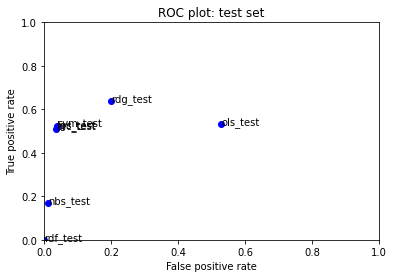

In [22]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [23]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='C:/Users/Dallas/Desktop/Machine Learning/toxiccomments_test.csv', my_random_seed=85, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 1048576)
Look at a few rows of the new quantitative features: 
   word_count  punc_count  punc_count2
0          72          10            0
1          13           1            0
2          16           0            0
3          38           3            0
4           7           1       

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [24]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = ols.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.5269776187615889


In [25]:
raw_data.head()

,id,comment_text,word_count,punc_count,punc_count2
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,72,10,0
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,13,1,0
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",16,0,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",38,3,0
4,00017695ad8997eb,I don't anonymously edit articles at all.,7,1,0


In [26]:
my_submission.head()

,id,prediction
0,00001cee341fdb12,False
1,0000247867823ef7,False
2,00013b17ad220c46,False
3,00017563c3f7919a,True
4,00017695ad8997eb,False


In [27]:
my_submission.shape

(153164, 2)

In [28]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('/home/ec2-user/data/toxiccomments_submission.csv', index=False)

FileNotFoundError: [Errno 2] No such file or directory: '/home/ec2-user/data/toxiccomments_submission.csv'

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation